In [1]:
import numpy as np
import mne
from pathlib import Path
import os
from cwt_spectrogram_Mads import cwt_spectrogram, spectrogram_plot
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

## Experimental

In [2]:
# Polysomnography (PSG) data
# A hypnogram is a file that contains the sleep stages (annotations) of the PSG data
# raw_data_path = Path("../SC4041E0-PSG.edf")
# annotation_path = Path("../SC4041EC-Hypnogram.edf") 

raw_data_path = Path("data/raw/SC4041/PSG/SC4041E0-PSG.edf")
annotation_path = Path("data/raw/SC4041/Hypnogram/SC4041EC-Hypnogram.edf")

In [3]:
# Load data: 
raw_train = mne.io.read_raw_edf(raw_data_path, stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel="Event Marker", there will be 3 eeg channels instead of 2 + a stimulus channel.
raw_train.filter(l_freq = 1, h_freq = None)

#Read annotations from hypnogram file
annot_train = mne.read_annotations(annotation_path)

annot_train = annot_train.crop(0, raw_train.times[-1]) # remove weird annotation at the end - what about all other files???
#Put the annotations into raw_train
raw_train.set_annotations(annot_train) # , emit_warning=False


Extracting EDF parameters from /mnt/c/Users/linsk/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DTU/code/ATML/project/data/raw/SC4041/PSG/SC4041E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_407307/2534567374.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(raw_data_path, stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel="Event Marker", there will be 3 eeg channels instead of 2 + a stimulus channel.
/tmp/ipykernel_407307/2534567374.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(raw_data_path, stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel="Event Marker", there will be 3 eeg channels instead of 2 + a stimulus channel.
/tmp/ipykernel_407307/2534567374.py:2: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_train = mne.io.read_raw_edf(raw_data_path, stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel=

Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)



<RawEDF | SC4041E0-PSG.edf, 7 x 7710000 (77100.0 s), ~411.8 MB, data loaded>

Note: there is a difference in psg data and annotation length. But cutting off the last annotation ( Sleep stage ?) we eg the exact equal amount. Thus removed above.


In [4]:
#np.unique(annot_train.description, return_counts=True)

In [5]:
# ss1 = [annototion['duration'] for annototion in annot_train if annototion['description'] == 'Sleep stage 1']
# ss2 = [annototion['duration'] for annototion in annot_train if annototion['description'] == 'Sleep stage 2']
# ss3 = [annototion['duration'] for annototion in annot_train if annototion['description'] == 'Sleep stage 3']
# rem = [annototion['duration'] for annototion in annot_train if annototion['description'] == 'Sleep stage R']
# wake = [annototion['duration'] for annototion in annot_train if annototion['description'] == 'Sleep stage W']

# # plot 5 histograms side by side ( couns of durations in ss1, ss2, ss3, wake, rem):
# fig, axs = plt.subplots(1, 5, figsize=(15, 3))
# for ax, data, title in zip(axs, [ss1, ss2, ss3, rem, wake], ['SS1', 'SS2', 'SS3', 'rem', 'wake']):
#     ax.hist(data, bins=30)
#     ax.set_title(title)

Note: annotation count * 30 will sum up to total time - 30 ( last wake annotation is not rounded)
160 annotations (1 of which is not used)
77100sek -> 2569 30sek windows (out of which 1 is Movement and last wake period is not rounded thus not make a full 30 sek period)

not including "Movement time" annotation above is equivalent to removing it after setting events

In [6]:
annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

# this line gets the events from the annotations
events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


In [7]:
#epochs, tmax?? and save txt - 

tmax = 30.0 - 1.0 / raw_train.info["sfreq"]  # tmax in included # tmax is the maximum time of the epoch

#Events are set as epochs; epochs a
epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=annotation_desc_2_event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)


Not setting metadata
2568 matching events found
No baseline correction applied
0 projection items activated


In [8]:
# from epochs train check class balance: 
# get lables:
lables = epochs_train.events[:,-1]
# count: 
np.unique(lables, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1533,  166,  620,   53,  196]))

In [ ]:
# N = 142
# example_signal = epochs_train.get_data().squeeze()[N,0,  :]  # [num_epoch, channel, time] -> [artibrary_epoch, first_channel, whole_30sek_window]

# plt.figure(figsize=(10, 4))

# time_step = np.arange(0, len(example_signal)) * (1 / raw_train.info['sfreq']) # create an array representing the time points corresponding to each sample in the EEG signal.
# plt.plot(time_step, example_signal)

# plt.title('EEG Signal - class ' f'{epochs_train.events[N][2]}')
# plt.xlabel('Seconds')
# plt.ylabel('Amplitude (uV)')
# plt.show()

In [ ]:
# plt.rcParams['figure.figsize'] = (16, 6)

# power, times, frequencies, coif = cwt_spectrogram(example_signal, raw_train.info['sfreq'], nNotes=4)

# #Plot the wavelet coefficients as spectrogram from spectrogram function
# img_1 = spectrogram_plot(power, times, frequencies, coif, cmap = 'jet', norm = LogNorm(), colorbar = None)

## Script

**Full script**
- ~~download 10-20 data files (50000/2500 = 20)~~
- make python script 
- make loader
- make saving - save to folder by file
- titans:
    - make env
    - upload data
    - make run script
    - test 
    - run


data/
├── raw/
│   ├── SC4001/
│   │   ├── PSG/
│   │   └── Hypnogram/
│   └── SC4101/
│       ├── PSG/
│       └── Hypnogram/
└── spectrograms/
    ├── labels.txt
    │       SC4001_001.png, 0
    │       SC4001_002.png, 2
    │       ...
    │       SC4101_001.png, 1
    └── images/
        ├── SC4001_001.png
        ├── SC4001_002.png
        ├── ...
        └── SC4101_001.png

*Note: only first day of each subject*

In [16]:
# 10 seconds
root_dir = Path("data/raw/")
#Direct to given folder, and make sure it exists
spectrogram_folder = Path('./data/spectrograms/images')
os.makedirs(spectrogram_folder, exist_ok=True)


subject_ids = [f"SC4{i:02d}1" for i in range(0, 11)]

all_psg_files = []
all_hypnogram_files = []

for subject_id in subject_ids:
    # subject_id_full = f"SC4{subject_id}1"
    psg_files = list(root_dir.rglob(f"{subject_id}/PSG/*.edf"))
    hypnogram_files = list(root_dir.rglob(f"{subject_id}/Hypnogram/*.edf"))
    all_psg_files.extend(psg_files)
    all_hypnogram_files.extend(hypnogram_files)


# make security check if they're not equal length:
assert len(all_psg_files) == len(all_hypnogram_files), "Number of PSG files and hypnogram files are not equal"


In [ ]:
mne.set_log_level('ERROR')

annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

for i in range(1): # 11 subjects
    raw_train = mne.io.read_raw_edf(all_psg_files[i], stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel="Event Marker", there will be 3 eeg channels instead of 2 + a stimulus channel.
    freq = raw_train.info['sfreq']
    assert freq == 100, f"Sampling frequency for file {all_psg_files[i]} is not 100"
    raw_train.filter(l_freq = 1, h_freq = None)
    annot_train = mne.read_annotations(all_hypnogram_files[i])
    annot_train = annot_train.crop(0, raw_train.times[-1]) # looks like all annotations have '?' at the end, so we can remove it
    raw_train.set_annotations(annot_train, emit_warning=True)

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0)

    tmax = 30.0 - 1.0 / freq  # tmax in included # tmax is the maximum time of the epoch
    #Events to epochs
    epochs_train = mne.Epochs(
        raw=raw_train,
        events=events_train,
        event_id=annotation_desc_2_event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,)

    
    epochs_train.get_data().squeeze()[:,0,  :]

    label_entries = []

    for i in range(len(epochs_train)):
        one_epoch = all_signals[i]
        plt.rcParams['figure.figsize'] = (16, 6)
        power, times, frequencies, coif = cwt_spectrogram(one_epoch, freq, nNotes=4)
        #Plot the wavelet coefficients as spectrogram from spectrogram function
        fig = spectrogram_plot(power, times, frequencies, coif, cmap = 'jet', norm = LogNorm(), colorbar = None)

        # Define the filename and save the figure
        image_name = f'{subject_id}_{i:03d}.png'
        spectro_filename = f'{spectrogram_folder}/{image_name}'
        fig.savefig(spectro_filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        fig.clf()

        # Get the label
        label = epochs_train.events[i][2]  # Assuming epochs_train is your label source
        # Append the filename and label to the list
        label_entries.append(f'{image_name}, {label}')

    label_file_path = f'{spectro_folder}/labels.txt'
    # make sure file exists:
    if not os.path.exists(label_file_path):
        with open(label_file_path, 'w') as label_file:
            label_file

    with open(label_file_path, 'a') as label_file:
        label_file.write('\n'.join(label_entries)) # + '\n')



In [9]:
import numpy as np
import mne
from pathlib import Path
import os
from cwt_spectrogram_Mads import cwt_spectrogram, spectrogram_plot
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter

mne.set_log_level('ERROR')


################
# Define data paths
input_data_dir = Path("data/raw/")

output_data_dir = Path("data/spectrograms/")
spectrogram_folder = Path(output_data_dir / "images")
label_file_path = f'{output_data_dir}/labels.txt'

# Create the output directories if they don't exist
os.makedirs(spectrogram_folder, exist_ok=True)

if not os.path.exists(label_file_path):
    with open(label_file_path, 'w') as label_file:
        label_file

################
subject_ids = [f"SC4{i:02d}1" for i in range(0, 11)]
all_psg_files = []
all_hypnogram_files = []

for subject_id in subject_ids:
    psg_files = list(input_data_dir.rglob(f"{subject_id}/PSG/*.edf"))
    hypnogram_files = list(input_data_dir.rglob(f"{subject_id}/Hypnogram/*.edf"))
    all_psg_files.extend(psg_files)
    all_hypnogram_files.extend(hypnogram_files)

assert len(all_psg_files) == len(all_hypnogram_files), "Number of PSG files and hypnogram files are not equal"


annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

for i in range(2): # len(all_psg_files)
    print(f"Processing {all_psg_files[i]}")
    subject_id = all_psg_files[i].parts[-3]
    raw_train = mne.io.read_raw_edf(all_psg_files[i], stim_channel="Event Marker", infer_types=True, preload=True) # without stim_channel="Event Marker", there will be 3 eeg channels instead of 2 + a stimulus channel.
    freq = raw_train.info['sfreq']
    assert freq == 100, f"Sampling frequency for file {all_psg_files[i]} is not 100"
    raw_train.filter(l_freq = 1, h_freq = None)
    
    annot_train = mne.read_annotations(all_hypnogram_files[i])
    annot_train = annot_train.crop(0, raw_train.times[-1]) # looks like all annotations have '?' at the end, so we can remove it
    raw_train.set_annotations(annot_train, emit_warning=True)

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0)
    tmax = 30.0 - 1.0 / freq
    epochs_train = mne.Epochs(
        raw=raw_train,
        events=events_train,
        event_id=annotation_desc_2_event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,)

    #####################################  
    # Step 1: Get the labels and their counts
    labels = epochs_train.events[:, -1]
    label_counts = dict(Counter(labels))
    # Step 2: Determine how many samples to keep per class (max 250 per class)
    max_samples_per_class = 250
    indices_to_keep = []
    for label, count in label_counts.items():
        # Get indices of all samples of this class
        class_indices = np.where(labels == label)[0]
        if count > max_samples_per_class:
            # Randomly select `max_samples_per_class` indices
            selected_indices = np.random.choice(class_indices, max_samples_per_class, replace=False)
        else:
            # Keep all indices if count is less than or equal to `max_samples_per_class`
            selected_indices = class_indices
        # Add the selected indices to the list of indices to keep
        indices_to_keep.extend(selected_indices)
    # Step 3: Filter `epochs_train` to keep only the selected indices
    epochs_train = epochs_train[indices_to_keep]    

    # print number of samples per class:
    print(f"Number of samples per class after filtering: {dict(Counter(epochs_train.events[:, -1]))}")
    #####################################

    epochs_train_formatted = epochs_train.get_data().squeeze()[:,0,  :]

    label_entries = []
    for i in tqdm(range(3)): # len(epochs_train_formatted)
        one_epoch = epochs_train_formatted[i]

        # Create the spectrogram
        plt.rcParams['figure.figsize'] = (16, 6)
        power, times, frequencies, coif = cwt_spectrogram(one_epoch, freq, nNotes=4)
        fig = spectrogram_plot(power, times, frequencies, coif, cmap = 'jet', norm = LogNorm(), colorbar = None)

        # Define the filename and save the figure
        image_name = f'{subject_id}_{i:03d}.png'
        spectro_filename = f'{spectrogram_folder}/{image_name}'
        fig.savefig(spectro_filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        fig.clf()

        # Get the label
        label = epochs_train.events[i][2]
        label_entries.append(f'{image_name}, {label}')

    # write labels to file
    with open(label_file_path, 'a') as label_file:
        label_file.write('\n'.join(label_entries) + '\n')


Processing data/raw/SC4001/PSG/SC4001E0-PSG.edf
Number of samples per class after filtering: {0: 250, 1: 58, 2: 250, 3: 220, 4: 125}


100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Processing data/raw/SC4011/PSG/SC4011E0-PSG.edf
Number of samples per class after filtering: {0: 250, 1: 109, 2: 250, 3: 105, 4: 170}


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


In [ ]:
# need to crop number of wakre from ~1500 to max other class num. 


In [4]:
import os

file_path = '/scratch/linsk/spectrograms/data/spectrograms/images/images/SC4081_236.png'
if os.path.exists(file_path):
    print("File exists")
else:
    print("File not found")

File exists


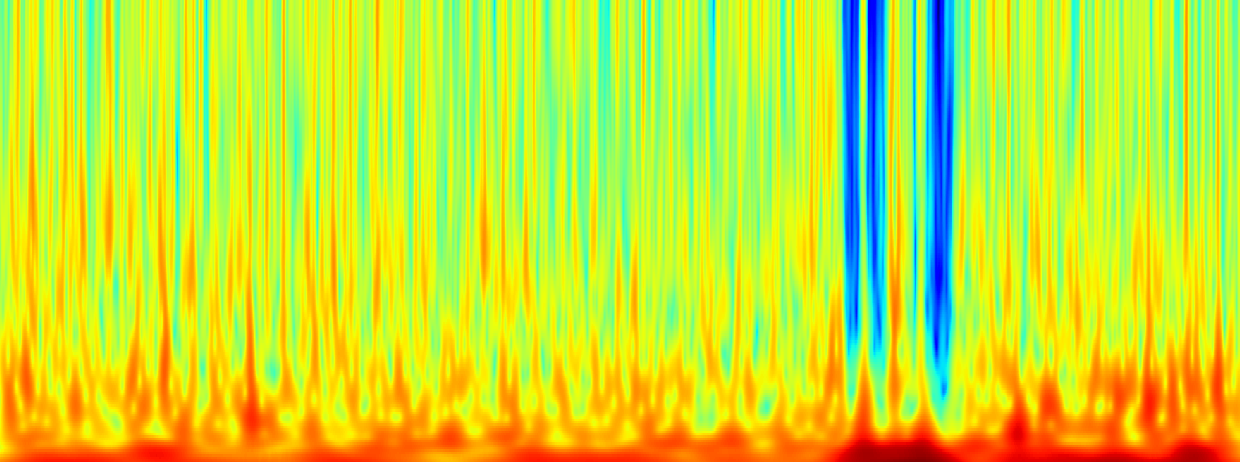

In [5]:
from PIL import Image

try:
    img = Image.open(file_path)
    img.show()  # If this works, the image will open
except Exception as e:
    print(f"Error opening image: {e}")
